In [1]:

# import torch
import numpy as np
import pandas as pd
import pandas.core.series
import math
import fastf1
import fastf1.core
from typing import List
from datetime import datetime
from pathlib import Path
import pickle
from f1winnerprediction import (
	config,
	utils,
	io_fastf1
)
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, roc_curve, auc, mean_absolute_error, r2_score, accuracy_score, f1_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns



pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


fastf1.Cache.enable_cache(config.FASTF1_RAW_CACHE_DIR.as_posix())


## Messing around


In [4]:
df = pd.DataFrame({
	 "Position": [1, 2, 5],
	 "B": [4, 5, 6]
})
df[["Position", "B"]].to_dict()

{'Position': {0: 1, 1: 2, 2: 5}, 'B': {0: 4, 1: 5, 2: 6}}

In [37]:
full_df = pd.DataFrame({'Position': range(1, 10)})

# Merge with race results on Position (outer join keeps all drivers)
final_df = pd.merge(full_df, df, on='Position', how='left')
final_df

,Position,B
0,1,4.0
1,2,5.0
2,3,NaN
3,4,NaN
4,5,6.0
5,6,NaN
6,7,NaN
7,8,NaN
8,9,NaN


In [38]:
session = fastf1.get_session(2021, 'Abu Dhabi', 'R')
df = session.load()

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

In [ ]:
output: pd.DataFrame = session.results
output

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps
33,33,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,0600EF,red_bull,Max,Verstappen,Max Verstappen,...,1.0,1,1.0,NaT,NaT,NaT,0 days 01:30:17.345000,Finished,26.0,58.0
44,44,L HAMILTON,HAM,hamilton,Mercedes,00D2BE,mercedes,Lewis,Hamilton,Lewis Hamilton,...,2.0,2,2.0,NaT,NaT,NaT,0 days 00:00:02.256000,Finished,18.0,58.0
55,55,C SAINZ,SAI,sainz,Ferrari,DC0004,ferrari,Carlos,Sainz,Carlos Sainz,...,3.0,3,5.0,NaT,NaT,NaT,0 days 00:00:05.173000,Finished,15.0,58.0
22,22,Y TSUNODA,TSU,tsunoda,AlphaTauri,2B4562,alphatauri,Yuki,Tsunoda,Yuki Tsunoda,...,4.0,4,8.0,NaT,NaT,NaT,0 days 00:00:05.692000,Finished,12.0,58.0
10,10,P GASLY,GAS,gasly,AlphaTauri,2B4562,alphatauri,Pierre,Gasly,Pierre Gasly,...,5.0,5,12.0,NaT,NaT,NaT,0 days 00:00:06.531000,Finished,10.0,58.0
77,77,V BOTTAS,BOT,bottas,Mercedes,00D2BE,mercedes,Valtteri,Bottas,Valtteri Bottas,...,6.0,6,6.0,NaT,NaT,NaT,0 days 00:00:07.463000,Finished,8.0,58.0
4,4,L NORRIS,NOR,norris,McLaren,FF9800,mclaren,Lando,Norris,Lando Norris,...,7.0,7,3.0,NaT,NaT,NaT,0 days 00:00:59.200000,Finished,6.0,58.0
14,14,F ALONSO,ALO,alonso,Alpine,0090FF,alpine,Fernando,Alonso,Fernando Alonso,...,8.0,8,11.0,NaT,NaT,NaT,0 days 00:01:01.708000,Finished,4.0,58.0
31,31,E OCON,OCO,ocon,Alpine,0090FF,alpine,Esteban,Ocon,Esteban Ocon,...,9.0,9,9.0,NaT,NaT,NaT,0 days 00:01:04.026000,Finished,2.0,58.0
16,16,C LECLERC,LEC,leclerc,Ferrari,DC0004,ferrari,Charles,Leclerc,Charles Leclerc,...,10.0,10,7.0,NaT,NaT,NaT,0 days 00:01:06.057000,Finished,1.0,58.0


In [ ]:
type(output)

fastf1.core.SessionResults

In [ ]:
utils.write_to_file(pd.DataFrame(output))

In [ ]:
output[["Abbreviation","GridPosition", "Position", "ClassifiedPosition"]]

,Abbreviation,GridPosition,Position,ClassifiedPosition
33,VER,1.0,1.0,1
44,HAM,2.0,2.0,2
55,SAI,5.0,3.0,3
22,TSU,8.0,4.0,4
10,GAS,12.0,5.0,5
77,BOT,6.0,6.0,6
4,NOR,3.0,7.0,7
14,ALO,11.0,8.0,8
31,OCO,9.0,9.0,9
16,LEC,7.0,10.0,10


In [ ]:
def create_columns_windows(df:pd.DataFrame, columns: List, window_size=5):
	df = df[columns]
	for col in df:
		# print(df[col])
		assert len(df[col]) >= window_size, f"window size < data length: {window_size} < {len(df[col])}"
		for i in range(len(df[col])):
			print(df[col][i:window_size+i])
			print("+++++++++++++++++++")

In [ ]:
create_columns_windows(output, ["GridPosition"])

33     1.0
44     2.0
55     5.0
22     8.0
10    12.0
Name: GridPosition, dtype: float64
+++++++++++++++++++
44     2.0
55     5.0
22     8.0
10    12.0
77     6.0
Name: GridPosition, dtype: float64
+++++++++++++++++++
55     5.0
22     8.0
10    12.0
77     6.0
4      3.0
Name: GridPosition, dtype: float64
+++++++++++++++++++
22     8.0
10    12.0
77     6.0
4      3.0
14    11.0
Name: GridPosition, dtype: float64
+++++++++++++++++++
10    12.0
77     6.0
4      3.0
14    11.0
31     9.0
Name: GridPosition, dtype: float64
+++++++++++++++++++
77     6.0
4      3.0
14    11.0
31     9.0
16     7.0
Name: GridPosition, dtype: float64
+++++++++++++++++++
4      3.0
14    11.0
31     9.0
16     7.0
5     15.0
Name: GridPosition, dtype: float64
+++++++++++++++++++
14    11.0
31     9.0
16     7.0
5     15.0
3     10.0
Name: GridPosition, dtype: float64
+++++++++++++++++++
31     9.0
16     7.0
5     15.0
3     10.0
18    13.0
Name: GridPosition, dtype: float64
+++++++++++++++++++
16     7.0

In [ ]:
session = fastf1.get_events_remaining(datetime(2021, 1, 1))
session.head(2)

req         WARNING 	DEFAULT CACHE ENABLED! (6.65 GB) /home/dhiabenhamouda/.cache/fastf1


,RoundNumber,Country,Location,OfficialEventName,EventDate,EventName,EventFormat,Session1,Session1Date,Session1DateUtc,...,Session3,Session3Date,Session3DateUtc,Session4,Session4Date,Session4DateUtc,Session5,Session5Date,Session5DateUtc,F1ApiSupport
0,0,Bahrain,Bahrain,FORMULA 1 ARAMCO PRE-SEASON TESTING 2021,2021-03-14,Pre-Season Test,testing,Practice 1,2021-03-12 10:00:00+03:00,2021-03-12 07:00:00,...,Practice 3,2021-03-14 10:00:00+03:00,2021-03-14 07:00:00,None,NaT,NaT,None,NaT,NaT,False
1,1,Bahrain,Sakhir,FORMULA 1 GULF AIR BAHRAIN GRAND PRIX 2021,2021-03-28,Bahrain Grand Prix,conventional,Practice 1,2021-03-26 14:30:00+03:00,2021-03-26 11:30:00,...,Practice 3,2021-03-27 15:00:00+03:00,2021-03-27 12:00:00,Qualifying,2021-03-27 18:00:00+03:00,2021-03-27 15:00:00,Race,2021-03-28 18:00:00+03:00,2021-03-28 15:00:00,True


In [ ]:
session.tail(2)

,RoundNumber,Country,Location,OfficialEventName,EventDate,EventName,EventFormat,Session1,Session1Date,Session1DateUtc,...,Session3,Session3Date,Session3DateUtc,Session4,Session4Date,Session4DateUtc,Session5,Session5Date,Session5DateUtc,F1ApiSupport
21,21,Saudi Arabia,Jeddah,FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2021,2021-12-05,Saudi Arabian Grand Prix,conventional,Practice 1,2021-12-03 16:30:00+03:00,2021-12-03 13:30:00,...,Practice 3,2021-12-04 17:00:00+03:00,2021-12-04 14:00:00,Qualifying,2021-12-04 20:00:00+03:00,2021-12-04 17:00:00,Race,2021-12-05 20:30:00+03:00,2021-12-05 17:30:00,True
22,22,Abu Dhabi,Yas Island,FORMULA 1 ETIHAD AIRWAYS ABU DHABI GRAND PRIX ...,2021-12-12,Abu Dhabi Grand Prix,conventional,Practice 1,2021-12-10 13:30:00+04:00,2021-12-10 09:30:00,...,Practice 3,2021-12-11 14:00:00+04:00,2021-12-11 10:00:00,Qualifying,2021-12-11 17:00:00+04:00,2021-12-11 13:00:00,Race,2021-12-12 17:00:00+04:00,2021-12-12 13:00:00,True


## Fetching Race history from previous years


### Init sessions object and dump file / path


In [2]:
# GP sessions
sessions: dict[int, list[fastf1.core.Session]] = {}
Path.mkdir(config.FASTF1_CHECKPOINT_DIR, exist_ok=True)

In [ ]:
sessions_dump_path = config.FASTF1_CHECKPOINT_DIR / "sessions_dump.pkl"

In [ ]:
# TODO: Create a is_dump_present function
try:
	sessions_dump_path.touch(exist_ok=False)
	is_dump_present = False
except FileExistsError:
	is_dump_present = True

is_dump_present

True

In [ ]:
# def save_checkpoint(checkpoint: dict = sessions, path: Path = sessions_dump_path):
# 	with open(path, "wb") as file:
# 	  pickle.dump(checkpoint, file)
	  
# def load_checkpoint(path: Path = sessions_dump_path) -> dict:
# 	checkpoint = {}
# 	with open(path, "rb") as file:
# 	 try:
# 		 checkpoint = pickle.load(file)
# 	 except EOFError as e:
# 		 logging.error(f"Empty dumpfile: {e}")
# 	 except Exception as e:
# 		 logging.error(f"Error loading checkpoint: {e}")

# 	 return checkpoint


### Loading checkpoint

#### Fetching number of GP for given years

In [ ]:
# YEARS : List = [2021, 2022, 2023, 2024, 2025]
# # YEARS : List = [2021]
# NUMBER_OF_GP = [fastf1.get_events_remaining(datetime(year, 1, 1))["RoundNumber"].max().item() for year in YEARS]
# NUMBER_OF_GP

[22]

In [ ]:
# # Verify that the dump is complete
# if is_dump_present:
# 	load_checkpoint(sessions_dump_path)
# 	#Make sure all years and gp are present
# 	# assert sessions.keys() == YEARS, "Missing years in the dump"
# 	if sessions.keys() == YEARS:
# 		logging.warning("Missing years in the dump")
# 	# assert all(len(sessions[year]) == NUMBER_OF_GP[i] for i, year in enumerate(YEARS)), "Missing GPs in the dump"
# 	if sessions.keys() != YEARS or not all(len(sessions[year]) == NUMBER_OF_GP[i] for i, year in enumerate(YEARS)):
# 		logging.warning("Missing GPs in the dump")

# sessions

{}

### Constructing sessions object from F1 cached data

In [ ]:
# checkpoint = {
# 	"year": 2021,
# 	"gp_index_start": 1
# }

In [ ]:
# # Load All needed Data
# sessions = {}
# years = YEARS
# number_of_gp = NUMBER_OF_GP
# gp_index_start = 1

# global_gp_index = 1
# global_year = 2021
# # Loading checkpoint
# if checkpoint["year"] is not None:
# 	progression_index = YEARS.index(checkpoint["year"])
# 	years = YEARS[progression_index:]
# 	number_of_gp = NUMBER_OF_GP[progression_index:]
# if checkpoint["gp_index_start"] is not None:
# 	gp_index_start = checkpoint["gp_index_start"]
	
# # Loading data and updating checkpoint at each iteration
# try:
# 	count = 0
# 	for year, nb_gp in zip(years, number_of_gp):
# 		global_year = year
# 		sessions[year] = []
# 		for gp_index in range(gp_index_start, nb_gp+1):
# 			global_gp_index = gp_index
# 			try:
# 				session = fastf1.get_session(year, gp_index, 'R')
# 			except Exception as e:
# 				logging.error(f"ERROR FETCHING SESSION: {year} {gp_index} - {e}")
# 				continue
# 			gp_name = session.event.EventName
# 			print(f"+------- FETCHING GP: {gp_name} {year} {gp_index}/{nb_gp} -------+")
# 			try:
# 				session.load()
# 			except Exception as e:
# 				logging.error(f"ERROR LOADING SESSION: {year} {gp_index} - {e}")
# 				continue
# 			sessions[year].append(session)
# 			count += 1
	
# 			if count % 5 == 0:
# 				logging.info("Saving checkpoint..")
# 				save_checkpoint(sessions, sessions_dump_path)
# 				checkpoint["year"] = year
# 				checkpoint["gp_index_start"] = gp_index
# 				count = 0
# except KeyboardInterrupt as e:
#    logging.info("Fetching interrupted by user, saving checkpoint..")
#    save_checkpoint(sessions, sessions_dump_path)
#    checkpoint = {
#        "year": global_year,
#        "gp_index_start": global_gp_index
#    }
# # Final save
# logging.info("Fetching complete, saving checkpoint..")
# save_checkpoint(sessions, sessions_dump_path)

io_fastf1.fetch_race_sessions_cache(config.YEARS_TO_FETCH)

core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


+------- FETCHING GP: Mexico City Grand Prix 2025 20/24 -------+


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '1', '87', '81', '12', '63', '44', '31', '5', '22', '23', '6', '18', '10', '43', '55', '14', '27', '30']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


+------- FETCHING GP: São Paulo Grand Prix 2025 21/24 -------+


logger      WARNING 	Failed to load session info data!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
core        WARNING 	Failed to load extended driver information!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
core        WARNING 	Failed to load driver list and session results!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
logger      WARNING 	Failed to load session status data!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
logger      WARNING 	Failed to load total lap count!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
logger      WARNING 	Failed to load track status data!
req            INFO 	No 

In [ ]:
# checkpoint

{'year': 2021, 'gp_index_start': 20}

### Save sessions dump


In [ ]:
io_fastf1.save_checkpoint(sessions, sessions_dump_path)

In [ ]:
sessions.keys()

dict_keys([2021])

## Data Loading

### Load sessions dump

In [ ]:
sessions = io_fastf1.load_checkpoint(sessions_dump_path)
sessions.keys(), sessions[2021]

(dict_keys([2021, 2022, 2023, 2024, 2025]),
 [2021 Season Round 1: Bahrain Grand Prix - Race,
  2021 Season Round 2: Emilia Romagna Grand Prix - Race,
  2021 Season Round 3: Portuguese Grand Prix - Race,
  2021 Season Round 4: Spanish Grand Prix - Race,
  2021 Season Round 5: Monaco Grand Prix - Race,
  2021 Season Round 6: Azerbaijan Grand Prix - Race,
  2021 Season Round 7: French Grand Prix - Race,
  2021 Season Round 8: Styrian Grand Prix - Race,
  2021 Season Round 9: Austrian Grand Prix - Race,
  2021 Season Round 10: British Grand Prix - Race,
  2021 Season Round 11: Hungarian Grand Prix - Race,
  2021 Season Round 12: Belgian Grand Prix - Race,
  2021 Season Round 13: Dutch Grand Prix - Race,
  2021 Season Round 14: Italian Grand Prix - Race,
  2021 Season Round 15: Russian Grand Prix - Race,
  2021 Season Round 16: Turkish Grand Prix - Race,
  2021 Season Round 17: United States Grand Prix - Race,
  2021 Season Round 18: Mexico City Grand Prix - Race,
  2021 Season Round 19: S

In [ ]:
sessions[2021][3].results.sort_values(by="Position", ascending=True)

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,HeadshotUrl,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps
44,44,L HAMILTON,HAM,hamilton,Mercedes,00D2BE,mercedes,Lewis,Hamilton,Lewis Hamilton,https://www.formula1.com/content/dam/fom-website/drivers/L/LEWHAM01_Lewis_Hamilton/lewham01.png.transform/1col/image.png,,1.0,1,1.0,NaT,NaT,NaT,0 days 01:33:07.680000,Finished,25.0,66.0
33,33,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,0600EF,red_bull,Max,Verstappen,Max Verstappen,https://www.formula1.com/content/dam/fom-website/drivers/M/MAXVER01_Max_Verstappen/maxver01.png.transform/1col/image.png,,2.0,2,2.0,NaT,NaT,NaT,0 days 00:00:15.841000,Finished,19.0,66.0
77,77,V BOTTAS,BOT,bottas,Mercedes,00D2BE,mercedes,Valtteri,Bottas,Valtteri Bottas,https://www.formula1.com/content/dam/fom-website/drivers/V/VALBOT01_Valtteri_Bottas/valbot01.png.transform/1col/image.png,,3.0,3,3.0,NaT,NaT,NaT,0 days 00:00:26.610000,Finished,15.0,66.0
16,16,C LECLERC,LEC,leclerc,Ferrari,DC0004,ferrari,Charles,Leclerc,Charles Leclerc,https://www.formula1.com/content/dam/fom-website/drivers/C/CHALEC01_Charles_Leclerc/chalec01.png.transform/1col/image.png,,4.0,4,4.0,NaT,NaT,NaT,0 days 00:00:54.616000,Finished,12.0,66.0
11,11,S PEREZ,PER,perez,Red Bull Racing,0600EF,red_bull,Sergio,Perez,Sergio Perez,https://www.formula1.com/content/dam/fom-website/drivers/S/SERPER01_Sergio_Perez/serper01.png.transform/1col/image.png,,5.0,5,8.0,NaT,NaT,NaT,0 days 00:01:03.671000,Finished,10.0,66.0
3,3,D RICCIARDO,RIC,ricciardo,McLaren,FF9800,mclaren,Daniel,Ricciardo,Daniel Ricciardo,https://www.formula1.com/content/dam/fom-website/drivers/D/DANRIC01_Daniel_Ricciardo/danric01.png.transform/1col/image.png,,6.0,6,7.0,NaT,NaT,NaT,0 days 00:01:13.768000,Finished,8.0,66.0
55,55,C SAINZ,SAI,sainz,Ferrari,DC0004,ferrari,Carlos,Sainz,Carlos Sainz,https://www.formula1.com/content/dam/fom-website/drivers/C/CARSAI01_Carlos_Sainz/carsai01.png.transform/1col/image.png,,7.0,7,6.0,NaT,NaT,NaT,0 days 00:01:14.670000,Finished,6.0,66.0
4,4,L NORRIS,NOR,norris,McLaren,FF9800,mclaren,Lando,Norris,Lando Norris,https://www.formula1.com/content/dam/fom-website/drivers/L/LANNOR01_Lando_Norris/lannor01.png.transform/1col/image.png,,8.0,8,9.0,NaT,NaT,NaT,NaT,+1 Lap,4.0,65.0
31,31,E OCON,OCO,ocon,Alpine,0090FF,alpine,Esteban,Ocon,Esteban Ocon,https://www.formula1.com/content/dam/fom-website/drivers/E/ESTOCO01_Esteban_Ocon/estoco01.png.transform/1col/image.png,,9.0,9,5.0,NaT,NaT,NaT,NaT,+1 Lap,2.0,65.0
10,10,P GASLY,GAS,gasly,AlphaTauri,2B4562,alphatauri,Pierre,Gasly,Pierre Gasly,https://www.formula1.com/content/dam/fom-website/drivers/P/PIEGAS01_Pierre_Gasly/piegas01.png.transform/1col/image.png,,10.0,10,12.0,NaT,NaT,NaT,NaT,+1 Lap,1.0,65.0


### Extracting Drivers list

In [2]:
drivers = set()

for year in sessions.keys():
	count = 0
	for session in sessions[year]:
		count += 1
		sessions_drivers = set(session.results["Abbreviation"])
		drivers.update(sessions_drivers)

sorted(drivers)
drivers, len(drivers)

NameError: name 'sessions' is not defined

In [ ]:
drivers_dict = {driver: idx for idx, driver in enumerate(sorted(drivers))}
drivers_dict

{'ALB': 0,
 'ALO': 1,
 'ANT': 2,
 'BEA': 3,
 'BOR': 4,
 'BOT': 5,
 'COL': 6,
 'DEV': 7,
 'DOO': 8,
 'GAS': 9,
 'GIO': 10,
 'HAD': 11,
 'HAM': 12,
 'HUL': 13,
 'KUB': 14,
 'LAT': 15,
 'LAW': 16,
 'LEC': 17,
 'MAG': 18,
 'MAZ': 19,
 'MSC': 20,
 'NOR': 21,
 'OCO': 22,
 'PER': 23,
 'PIA': 24,
 'RAI': 25,
 'RIC': 26,
 'RUS': 27,
 'SAI': 28,
 'SAR': 29,
 'STR': 30,
 'TSU': 31,
 'VER': 32,
 'VET': 33,
 'ZHO': 34}

## Data Transformation

### Aggregate drivers race position for save grand prix sessions

In [7]:
drivers_dict = io_fastf1.build_drivers_dict(sessions)
drivers_dict

AttributeError: module 'f1winnerprediction.io_fastf1' has no attribute 'build_drivers_dict'

In [4]:
df_drivers = pd.DataFrame({'Abbreviation': drivers_dict.keys()})
df_raceonly = df_drivers.copy()
df_qualirace = df_drivers.copy()
for year in sessions.keys():
	for session in sessions[year]:
		event_name = session.event.EventName
		event_name_year = event_name + "_" + str(year)
		session_results = session.results[["Abbreviation", "GridPosition", "Position"]].copy()
		session_results.rename(columns={
     "GridPosition": f"{event_name_year}_GridPosition",
     "Position": f"{event_name_year}_Position"}, inplace=True)
		df_raceonly = pd.merge(df_raceonly, session_results[["Abbreviation", f"{event_name_year}_Position"]], on='Abbreviation', how='left')
		df_qualirace = pd.merge(df_qualirace, session_results[["Abbreviation", f"{event_name_year}_GridPosition", f"{event_name_year}_Position"]], on='Abbreviation', how='left')
		session.results.sort_values(by="Abbreviation", ascending=True, inplace=True)

df_raceonly

NameError: name 'drivers_dict' is not defined

### Create dataset windowns

In [ ]:
def create_columns_windows_raceonly(df:pd.DataFrame, windows_index_start=1, windows_size=5, stride=1):
	df_windows = pd.DataFrame(columns=[f"race{i}" for i in range(windows_size)])
	
	# all_windows = []
	length = df.shape[1] - windows_index_start
	nb_windows = math.floor((length - windows_size)/stride) + 1
	race: pandas.core.series.Series
	for index, race in df.iterrows():
		for window_index in range(nb_windows):
			window_name = f"window_{window_index}"
			start_col_index = windows_index_start + window_index * stride
			end_col_index = start_col_index + windows_size
			window = race[start_col_index:end_col_index]
			# exclude windows with NaN values
			if window.isnull().any():
				continue
			df_windows.loc[len(df_windows)] = window.values  
			# print(window)	
			# print("+++++++++++++++++++")

	return df_windows
start = datetime.now()
df_windows = io_fastf1.create_columns_windows_raceonly(df_raceonly, windows_size=5)
end = datetime.now()
end - start

datetime.timedelta(seconds=3, microseconds=846614)

In [ ]:
def create_columns_windows_raceonly(df:pd.DataFrame, windows_index_start=1, windows_size=5, stride=1):
	df_windows = pd.DataFrame(columns=[f"race{i}" for i in range(windows_size)])
	
	# all_windows = []
	length = df.shape[1] - windows_index_start
	nb_windows = math.floor((length - windows_size)/stride) + 1
	race: pandas.core.series.Series
	for _, race in df.iterrows():
		window_index = 0
		while window_index < nb_windows:
		# for window_index in range(nb_windows):
			window_name = f"window_{window_index}"
			start_col_index = windows_index_start + window_index * stride
			end_col_index = start_col_index + windows_size
			window = race[start_col_index:end_col_index]
			# exclude windows with NaN values
			if window.isnull().any():
				# find last null within the window and set it to the current window_index
				nan_pos = np.where(window.isnull().to_numpy())[0]
				last_nan_pos = nan_pos[-1]
				print(f"Skipping window {window_name} due to NaN at position(s) {nan_pos}, jumping to window_index {window_index + last_nan_pos}")
				window_index += 1 + last_nan_pos
				continue
			df_windows.loc[len(df_windows)] = window.values  
			window_index += 1
			# print(window)	
			# print("+++++++++++++++++++")

	return df_windows
start = datetime.now()
df_windows = create_columns_windows_raceonly(df_raceonly, windows_size=10)
end = datetime.now()
end - start

Skipping window window_0 due to NaN at position(s) [0 1 2 3 4 5 6 7 8 9], jumping to window_index 9
Skipping window window_10 due to NaN at position(s) [0 1 2 3 4 5 6 7 8 9], jumping to window_index 19
Skipping window window_20 due to NaN at position(s) [0 1], jumping to window_index 21
Skipping window window_28 due to NaN at position(s) [9], jumping to window_index 37
Skipping window window_101 due to NaN at position(s) [9], jumping to window_index 110
Skipping window window_101 due to NaN at position(s) [9], jumping to window_index 110
Skipping window window_0 due to NaN at position(s) [0 1 2 3 4 5 6 7 8 9], jumping to window_index 9
Skipping window window_10 due to NaN at position(s) [0 1 2 3 4 5 6 7 8 9], jumping to window_index 19
Skipping window window_20 due to NaN at position(s) [0 1 2 3 4 5 6 7 8 9], jumping to window_index 29
Skipping window window_30 due to NaN at position(s) [0 1 2 3 4 5 6 7 8 9], jumping to window_index 39
Skipping window window_40 due to NaN at position(s

datetime.timedelta(seconds=4, microseconds=434144)

In [ ]:
df_windows.shape

(1772, 10)

## Data Preparation

### Data and label split

In [103]:
def data_label_split(df_windows: pd.DataFrame):
	X = df_windows.iloc[:, :-1].values
	y = df_windows.iloc[:, -1].values
	return X, y

In [105]:
for col in df_windows:
   df_windows[col] = pd.to_numeric(df_windows[col], errors='coerce')

In [106]:
X, Y = data_label_split(df_windows)

### Normalize Data

In [107]:
X = (X - X.mean()) / X.std()

### Adjust Y to be zero-indexed | from range (1, 21) to range(20)

In [108]:
Y = Y - 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1417, 9), (355, 9), (1417,), (355,))

num_classes = int(y_train.max())  # usually 20
params = dict(
    objective="multi:softprob",   # softmax probability output
    eval_metric="mlogloss",
    num_class=num_classes,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    n_estimators=500,
    random_state=42,
)

clf = xgb.XGBClassifier(**params)
clf.fit(X_train, y_train)


# Model Training

## Model v1: Simple | previous race history

### XGBResgressor

In [30]:
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,

)

In [31]:
model.fit(X_train, y_train.astype(int))

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [32]:
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MAE: 3.900347442190412
R²: 0.27247156280953533


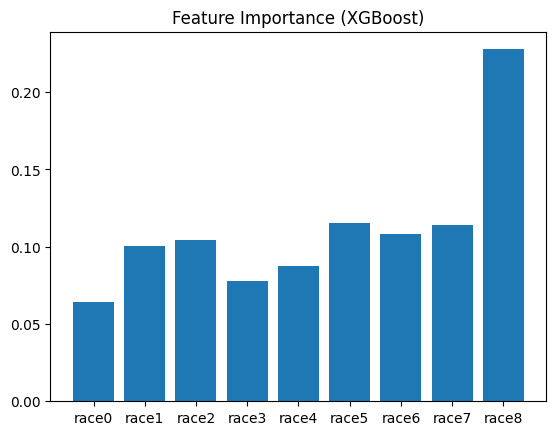

In [34]:
xgb_importance = model.feature_importances_
plt.bar(X.columns, xgb_importance)
plt.title("Feature Importance (XGBoost)")
plt.show()


### XGBClassifier

In [59]:
num_classes = 20
params = dict(
    objective="multi:softprob",
    eval_metric="mlogloss",
    num_class=num_classes,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    n_estimators=500,
)

clf = XGBClassifier(**params)
clf.fit(X_train, y_train)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [61]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.10985915492957747
F1 Score: 0.10689286541714238


array([ 7,  1,  3, 14,  9, 12,  6,  0, 16, 16,  2, 10,  2, 10,  9,  0, 10,
        3, 13, 12, 10,  3,  8,  7,  0, 19,  0, 18,  2,  1,  6,  8,  9,  5,
        1,  8,  6, 13, 15,  5,  5, 18, 17, 16,  6, 19, 17,  2,  7,  1,  3,
       18,  1,  5,  3, 10,  2, 14,  2,  8,  9,  2, 19, 18,  6,  6, 10,  7,
       13, 14,  5, 11,  1, 15,  2, 15, 18,  8, 15,  1, 17,  0,  3,  4,  5,
        2, 18, 15,  4, 12,  3, 17, 15,  4,  0,  4,  7,  2, 12, 10,  5,  6,
        0, 16, 12, 13,  4, 11,  3, 19,  0, 14,  5,  4, 19, 12,  4,  3, 11,
        9, 18,  8,  7,  8,  0,  4,  5, 13,  4,  8, 16, 13,  6, 17, 11, 16,
        3, 12, 11, 17, 11,  9, 18,  1, 13, 19, 15,  3, 18,  6, 18, 14,  2,
       10, 16, 18, 13,  4,  9, 11, 16,  6,  8,  7, 18, 14,  6,  5, 11, 15,
        3, 12, 17,  0,  0, 18, 13,  1, 13, 11,  8, 13,  3,  3, 15,  6,  6,
       10,  7, 10, 18, 14,  1,  8, 13,  4,  6,  4, 15,  4, 12,  8, 13,  9,
       13, 18,  8,  4, 19, 14, 16, 18,  5,  1, 18,  7, 12, 11, 10,  0,  9,
       10, 16,  6,  6, 19

In [ ]:
# Predicted class probabilities shape = (num_samples, num_classes)
probs = clf.predict_proba(X_test)
preds: np.ndarray = np.argmax(probs, axis=1)   # +1 because positions start at 1

In [97]:
y_test.value_counts().sort_index()

race9
0.0     16
1.0     26
2.0     14
3.0     18
4.0     20
5.0     24
6.0     23
7.0     16
8.0     20
9.0     11
10.0    14
11.0    19
12.0    13
13.0    14
14.0    16
15.0    27
16.0    18
17.0    20
18.0    12
19.0    14
Name: count, dtype: int64

In [ ]:
set(n.item() for n in sorted(list(preds)))


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

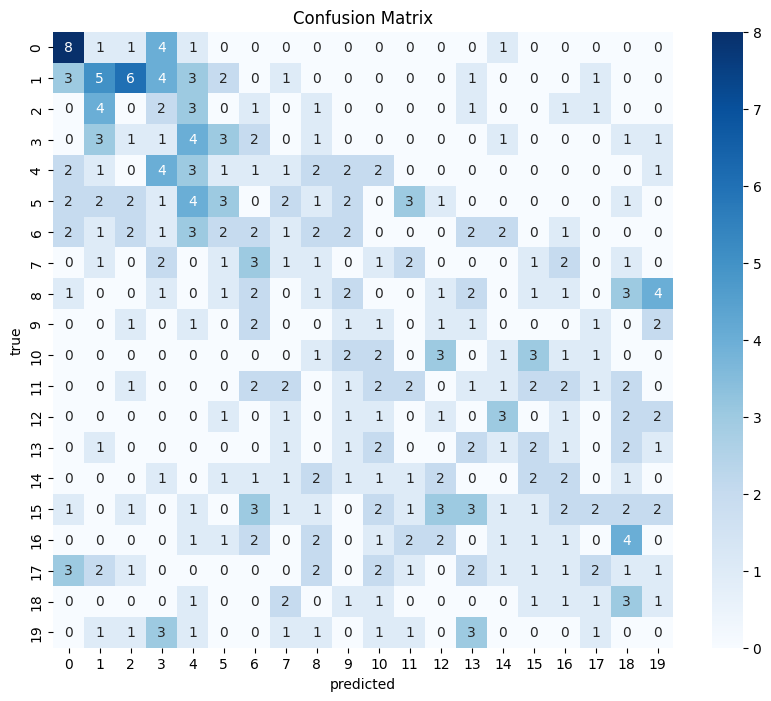

In [99]:
cm = confusion_matrix(y_test, preds, labels=range(num_classes))


cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('Confusion Matrix')
plt.show()

Macro AUC: 0.6595079721493784


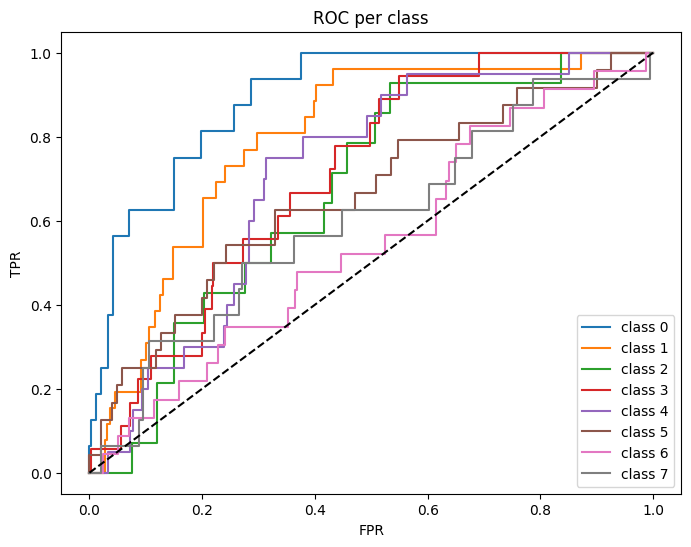

In [100]:
# ROC AUC (multiclass one-vs-rest) & ROC curves
y_bin = label_binarize(y_test, classes=np.arange(num_classes))
# probs shape = (n_samples, num_classes)
print("Macro AUC:", roc_auc_score(y_bin, probs, average='macro', multi_class='ovr'))
# plot few per-class ROC
plt.figure(figsize=(8,6))
for i in range(min(8, num_classes)):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'class {i}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC per class')
plt.show()

In [101]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score
acc = accuracy_score(y_test, preds)
top3 = top_k_accuracy_score(y_test, probs, k=3, labels=np.arange(num_classes))
print(f"Top-1 acc = {acc:.3f}, Top-3 acc = {top3:.3f}")

Top-1 acc = 0.110, Top-3 acc = 0.279


## Model v2: More in depth | Adding Quali results